In [1]:
from denoising_diffusion_pytorch import Unet, GaussianDiffusion, Trainer

In [2]:
# Load the dataset from the huggingface hub
from datasets import load_dataset
cifar10 = load_dataset('cifar10')
cifar10['train'][0]

Reusing dataset cifar10 (C:\Users\dsi224\.cache\huggingface\datasets\cifar10\plain_text\1.0.0\447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4)


  0%|          | 0/2 [00:00<?, ?it/s]

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x23852E66A90>,
 'label': 0}

In [3]:
# Save the images to a folder for convenience
!mkdir -p train_images
def save_im(x, i):
  x['img'].save(f'train_images/{i:05}.png')
_ = cifar10['train'].map(save_im, with_indices=True)

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file train_images already exists.
Error occurred while processing: train_images.


  0%|          | 0/50000 [00:00<?, ?ex/s]

In [4]:
# Create the unet model
model = Unet(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
).cuda()

In [5]:
# Rough parameter count:
sum([p.numel() for p in model.parameters()]) # About the same as the 35 million in the paper

36255235

In [6]:
diffusion = GaussianDiffusion(
    model,
    image_size = 32,    # <<< Not 128
    timesteps = 1000,   # number of steps
    beta_schedule = 'linear', # <<< TO follow paper
    loss_type = 'l2'    # <<< I think they do MSE (l2) loss but double check
).cuda()

In [7]:
trainer = Trainer(
    diffusion,
    'train_images',
    augment_horizontal_flip = True,   # Some augmentation as in paper since this is a small dataset
    train_batch_size = 30,           # <<< You may need to tweak based on available GPU memory
    train_lr = 1e-5,
    train_num_steps = 1000,           # <<< Adjust as needed
    gradient_accumulate_every = 2,    # gradient accumulation steps
    ema_decay = 0.95,                 # <<< I'm using a higher EMA decay
    ema_update_every = 10,            # <<< And only updating the ema model every 10 steps to save compute
    amp = True                        # turn on mixed precision
)

In [8]:
trainer.train() #It starts with 20-30 seconds delay.

loss: 0.0743: 100%|██████████| 1000/1000 [08:42<00:00,  1.92it/s]

training complete


In [9]:
sampled_images = diffusion.sample(batch_size = 4)
sampled_images.shape # (4, 3, 128, 128)

sampling loop time step: 100%|██████████| 1000/1000 [00:29<00:00, 33.64it/s]


torch.Size([4, 3, 32, 32])

In [16]:
import matplotlib.pyplot as plt

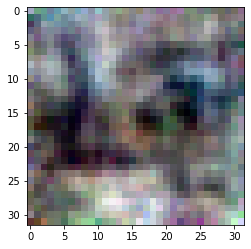

In [27]:
plt.imshow(sampled_images[1].permute(1,2,0).cpu())
plt.show()

In [15]:
import torch
d=torch.random(3)

TypeError: 'module' object is not callable